**Objetivo**:

Entrenar y optimizar un modelo de k-means clustering utilizando datos de precios de viviendas en California. Utilizaremos datos de ubicación (latitud y longitud) y el valor medio de las viviendas para observar cómo fluctúan los
precios en distintas zonas del estado.

Además, ajustaremos el número de clústeres mediante la técnica del codo (Elbow
Method)para encontrar el número óptimo de grupos.

*Me apoyaré del modelo CloudSonet4 para hacer el EDA*

In [93]:
#importaciones y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Configuración para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 8)

In [94]:
# Cargar el dataset
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Información del dataset

In [95]:
# Dimensiones del dataset
print(f"Dimensiones: {df.shape}")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

# Información general
print(df.info())


# Nombres de columnas
print(df.columns.tolist())


Dimensiones: (20640, 10)
Filas: 20640, Columnas: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


Este dataset tiene:

✓ 20640 filas y 11 columnas


✓ Variables numéricas: 9


'longitude', 'latitude', 'total_bedrooms', 'median_income', 'median_house_value',  'rooms_per_household', 'population_per_household'

✓ Variables categóricas: 1

'ocean_proximity'


✓ Total de valores nulos: 207

**Análisis de Nulos**

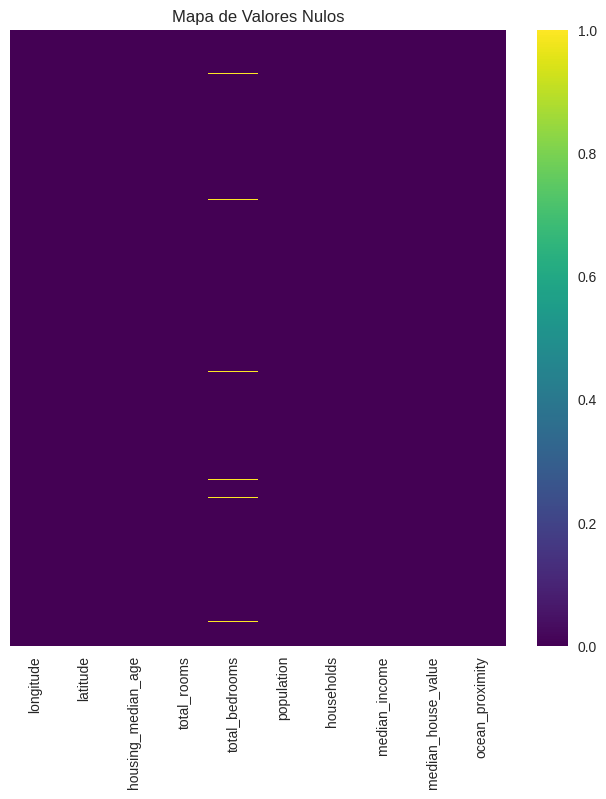

In [96]:
#Suma de nulos
df.isnull().sum()


# Visualización de valores nulos
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Nulos')
plt.show()


De las  20640 entradas, hay un total de 207 valores nulos, solamente en la columna "total_bedrooms", que dice el total de las habitaciones destinadas a dormitorio.

**Al ser una cifra relativamente pequeña (1% aproximadamente en el dataset) más adelante imputaré los valores usando el promedio**

In [97]:
# Estadísticas para variables numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("\nESTADÍSTICAS PARA VARIABLES NUMÉRICAS:")
print(df[numeric_columns].describe())

# Estadísticas para variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print("\nESTADÍSTICAS PARA VARIABLES CATEGÓRICAS:")
    print(df[categorical_columns].describe())


ESTADÍSTICAS PARA VARIABLES NUMÉRICAS:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.00000

El rango de valores de median_income y median_house_value sugiere una gran desigualdad económica entre las zonas.


Algunas variables presentan outliers, como total_rooms y population, que podrían afectar el modelos(Haremos transformqciones con estos datos más adelane para que tengan más valor para el modelo).


La variable categórica "ocean_proximity" es potencialmente predictiva para el valor de la vivienda, dada su relación con la ubicación.

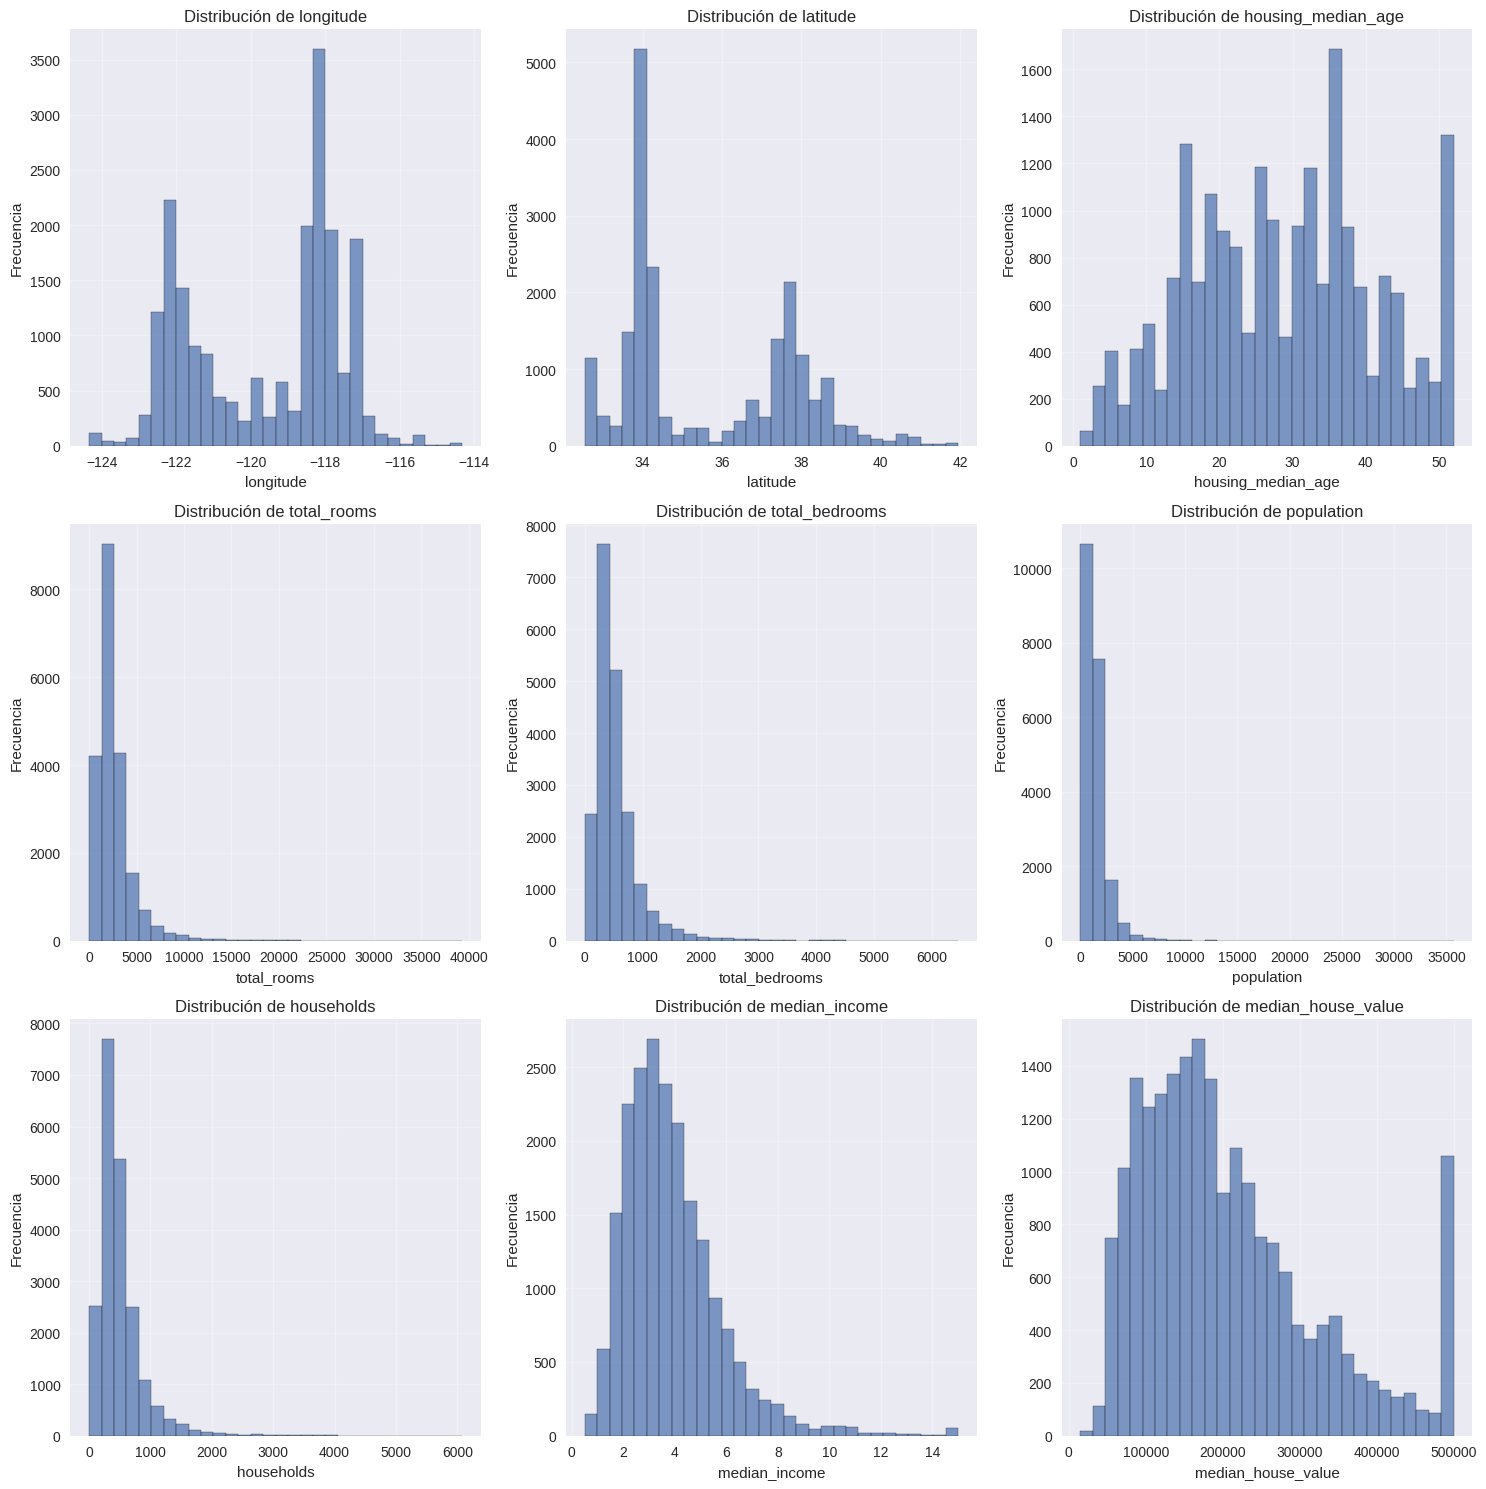

In [98]:
# Histogramas para variables numéricas
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df[column].dropna(), bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

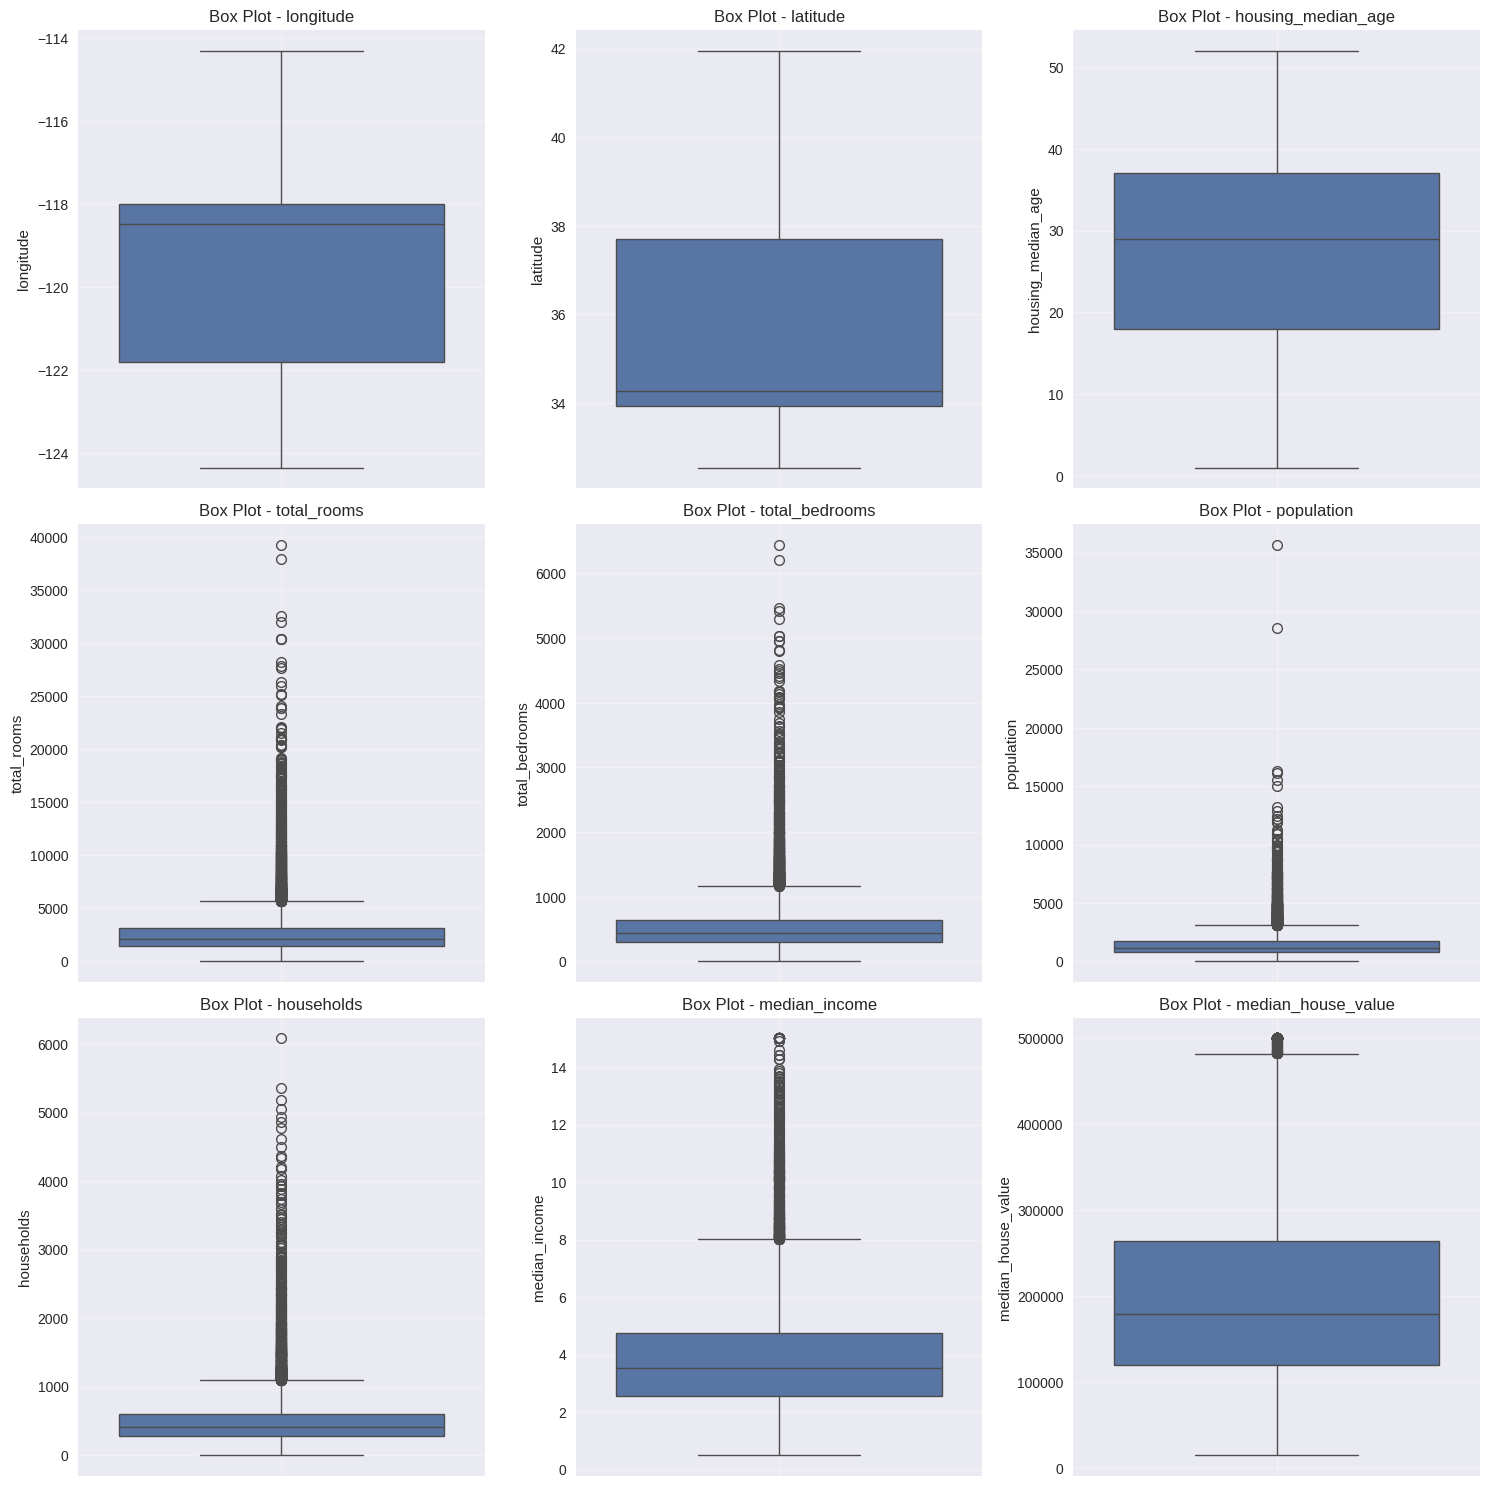

In [99]:
# Box plots para detectar outliers
plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot - {column}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

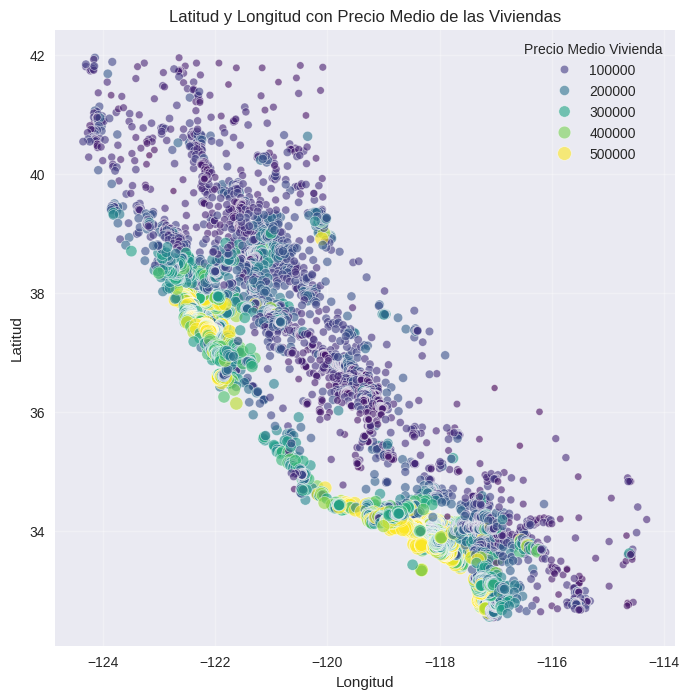

In [100]:
#grafico de dispersión  de latitud y longitud junto con el precio medio de las viviendas mediante un gráfico de dispersión.
sns.scatterplot(x='longitude', y='latitude', hue='median_house_value', size='median_house_value', data=df, palette='viridis', alpha=0.6)
plt.title('Latitud y Longitud con Precio Medio de las Viviendas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Precio Medio Vivienda')
plt.grid(True, alpha=0.3)
plt.show()

Las casas tienden a valer menos hacia el norte

Con la matriz de correlaciones podremos observar cómo se correlacionanlas variables con la slaida y entre ellas


MATRIZ DE CORRELACIÓN:
                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035   

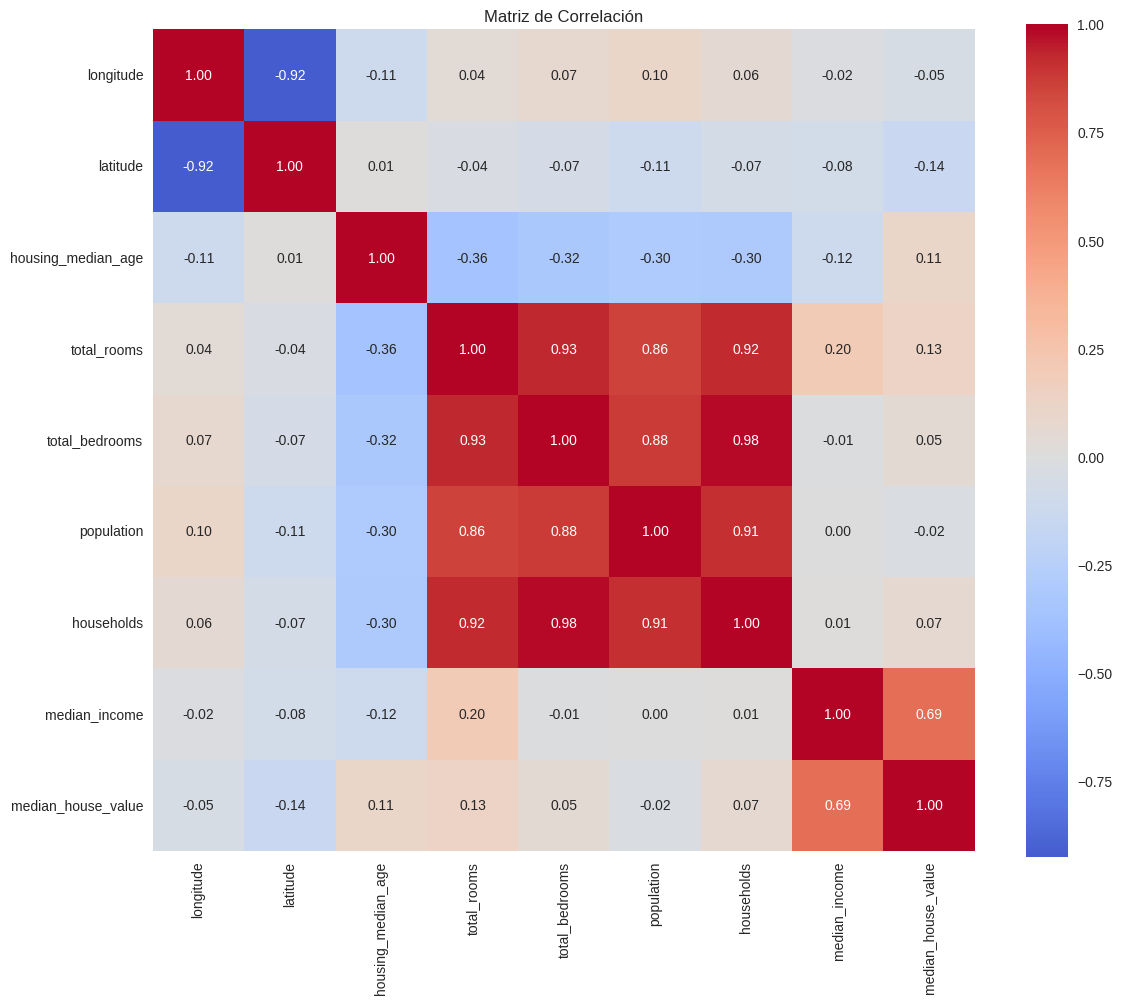

In [101]:
# Matriz de correlación
correlation_matrix = df[numeric_columns].corr()
print("\nMATRIZ DE CORRELACIÓN:")
print(correlation_matrix)

# Heatmap de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()


In [102]:
# Correlaciones más fuertes (excluyendo la diagonal)
correlations_abs = correlation_matrix.abs()
upper_tri = correlations_abs.where(
    np.triu(np.ones_like(correlations_abs, dtype=bool), k=1)
)
strong_correlations = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        if pd.notna(upper_tri.loc[idx, col]) and upper_tri.loc[idx, col] > 0.5:
            strong_correlations.append((idx, col, correlation_matrix.loc[idx, col]))

print("\nCORRELACIONES FUERTES (|r| > 0.5):")
for var1, var2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} - {var2}: {corr:.3f}")


CORRELACIONES FUERTES (|r| > 0.5):
total_bedrooms - households: 0.980
total_rooms - total_bedrooms: 0.930
longitude - latitude: -0.925
total_rooms - households: 0.918
population - households: 0.907
total_bedrooms - population: 0.878
total_rooms - population: 0.857
median_income - median_house_value: 0.688


En este mapa de calor podemos observar fuertes correlaciones como
total_rooms y total_bedrooms;
total_bedrooms y households (0.98);population, total_rooms (0.86), households (0.91)
**median_income y median_house_value (0.69)**

Como es lógico : más habitaciones=más dormitorios=más hogares=más población.

Por otro lado destacan las correlaciones negativas:
**longitude y latitude (-0.92)**, osea que cuando aumenta la longitud, disminuye la latitud.
y latitude con median_house_value


**Las casas tienden a valer menos hacia el norte**

La salida tiene baja correlación con otras variables como total_rooms (0.13), households (0.07), o population (-0.02), lo cual indica que por sí solas estas variables no explican mucho del precio de las casas.


In [103]:
#  ANÁLISIS DE OUTLIERS

print("\n" + "=" * 50)
print("ANÁLISIS DE OUTLIERS")
print("=" * 50)

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

print("OUTLIERS POR VARIABLE (método IQR):")
for column in numeric_columns:
    outliers = detect_outliers_iqr(df[column])
    outlier_percentage = (len(outliers) / len(df)) * 100
    print(f"{column}: {len(outliers)} outliers ({outlier_percentage:.2f}%)")



ANÁLISIS DE OUTLIERS
OUTLIERS POR VARIABLE (método IQR):
longitude: 0 outliers (0.00%)
latitude: 0 outliers (0.00%)
housing_median_age: 0 outliers (0.00%)
total_rooms: 1287 outliers (6.24%)
total_bedrooms: 1271 outliers (6.16%)
population: 1196 outliers (5.79%)
households: 1220 outliers (5.91%)
median_income: 681 outliers (3.30%)
median_house_value: 1071 outliers (5.19%)


No se detectaron outliers en las variables geográficas (longitude, latitude) ni en la edad mediana de las viviendas (housing_median_age).


Las variables relacionadas con el tamaño de las viviendas y la demografía, como total_rooms (6.24%), total_bedrooms (6.16%), population (5.79%) y households (5.91%), presentan un porcentaje moderado de outliers, probablemente asociado a zonas con densidades o tamaños inusuales.


Las variables económicas también presentan valores atípicos: median_income con un 3.30% y median_house_value con un 5.19%, lo que puede indicar la presencia de zonas con ingresos o precios significativamente distintos al resto.



ANÁLISIS DE VARIABLES CATEGÓRICAS

VALORES ÚNICOS EN ocean_proximity:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


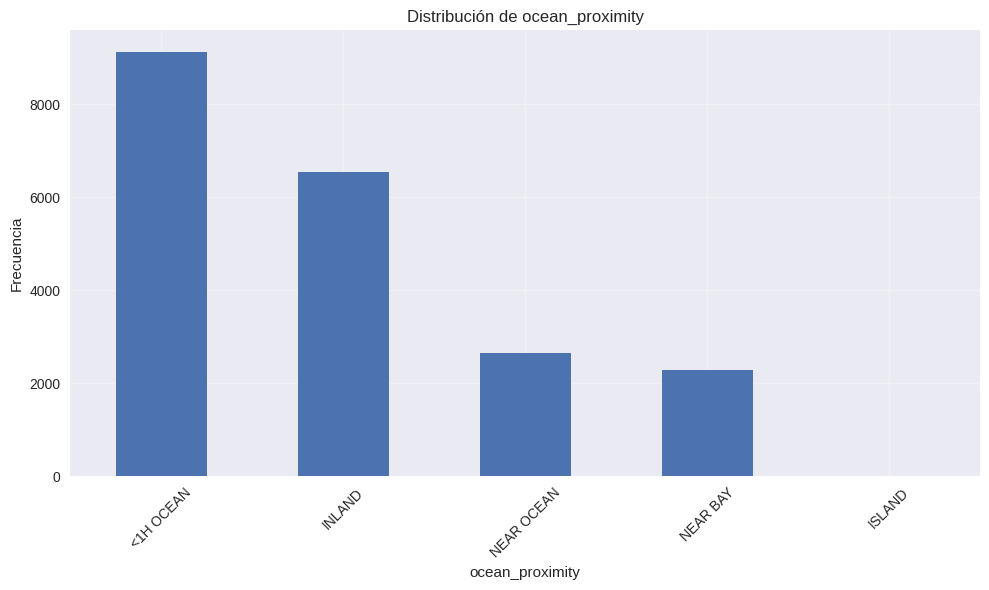

In [104]:
if len(categorical_columns) > 0:
    print("\n" + "=" * 50)
    print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
    print("=" * 50)

    for column in categorical_columns:
        print(f"\nVALORES ÚNICOS EN {column}:")
        value_counts = df[column].value_counts()
        print(value_counts)

        # Gráfico de barras
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Distribución de {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

La variable categórica ocean_proximity indica la cercanía de las viviendas al océano y presenta la siguiente distribución:

La categoría más frecuente es <1H OCEAN, que representa a las viviendas ubicadas a menos de una hora del océano.
Le sigue INLAND, que corresponde a zonas más alejadas del mar.
Las categorías NEAR OCEAN y NEAR BAY tienen menor representación, indicando zonas costeras más específicas.
**La categoría ISLAND es prácticamente inexistente en el conjunto de datos.**


Esta variable podría tener un impacto importante en el valor de las viviendas, por lo que será interesante analizar su relación con median_house_value en el análisis posterior.

Además observar que el número de habitaciones no influye en el valor de la casa, sin embargo **los ingresos promedios** y la **Proximidad sí**, mientras mayor son los ingresos mayor el valor de la cassa, y cuanto **más** cerca se encuentra del mar, **más** valor tiene

# Tratamiento de Datos

In [105]:
#Reemplazo los nulos de total bedrooms por la media
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

#Verifico
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Combinamos las filas para que sean de mayor valor para el modelo

In [106]:

#Combino las filas de rooms_per_household = total_rooms / households
df['rooms_per_household'] = df['total_rooms'] / df['households']

#Combino las filas de population_per_household = population / households
df['population_per_household'] = df['population'] / df['households']

#verifico las filas
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467


In [107]:
#Elimino las variables qu eestán correlacionadas entre sí

df.drop(['total_rooms', 'households', 'population', 'housing_median_age'], axis=1, inplace=True)

#verifico las filas
df.head()



,longitude,latitude,total_bedrooms,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household
0,-122.23,37.88,129.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556
1,-122.22,37.86,1106.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842
2,-122.24,37.85,190.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260
3,-122.25,37.85,235.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945
4,-122.25,37.85,280.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467


In [108]:
 #Mapeo ocean_proximity

mapeo = {"<1H OCEAN": 1, "INLAND": 2, "NEAR OCEAN": 3, "NEAR BAY": 4, "ISLAND": 5}
df["ocean_proximity"] = df["ocean_proximity"].map(mapeo)

print(df.head())

   longitude  latitude  total_bedrooms  median_income  median_house_value  \
0    -122.23     37.88           129.0         8.3252            452600.0   
1    -122.22     37.86          1106.0         8.3014            358500.0   
2    -122.24     37.85           190.0         7.2574            352100.0   
3    -122.25     37.85           235.0         5.6431            341300.0   
4    -122.25     37.85           280.0         3.8462            342200.0   

   ocean_proximity  rooms_per_household  population_per_household  
0                4             6.984127                  2.555556  
1                4             6.238137                  2.109842  
2                4             8.288136                  2.802260  
3                4             5.817352                  2.547945  
4                4             6.281853                  2.181467  


# Modelo

Normalizamos los datos

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['latitude', 'longitude']], df[['median_house_value']], test_size=0.33, random_state=0)

In [110]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [111]:
# Parámetros del modelo
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)


KMeans(n_clusters=3, random_state=0)

<Axes: xlabel='longitude', ylabel='latitude'>

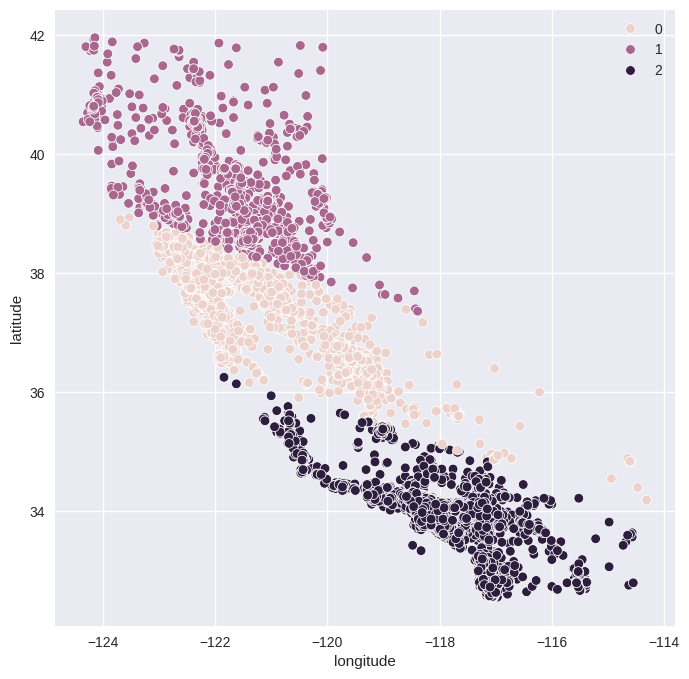

In [82]:
#Visualizamos

sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

<Axes: ylabel='median_house_value'>

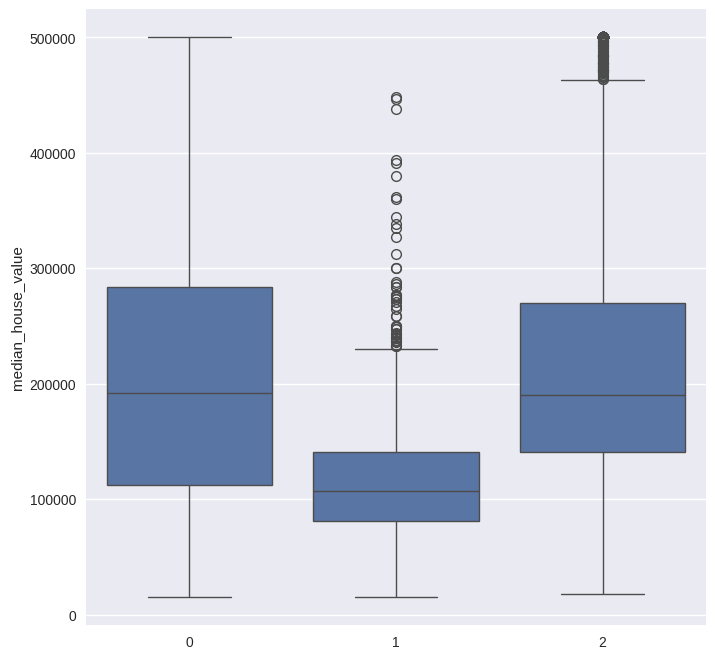

In [83]:
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'])

Podemos observar que se han agrupado los datos en tres grupos, dos de ellos se han distribuido bastante bien, sin embargo en uno de ellos existe gran cantidad de outlayers


A continuación calculamos el número de
 Silhouette **a menor puntuación, mejor ajuste**

In [84]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

np.float64(0.7499371920703546)

El número de silohutte es satisfactorio, o sea la división de clusters es bastante buena (cerca de 1 significa que hay una clara separación de los datos).

Sin embargo, si no entrenamos el modelo con otros valores de k, no sabemos cuál es el nñumero de k **más eficiente**

In [85]:
#entrenamos el modelo con distintos valores de k del 2-8
K = range(2, 8)
fits = []
score = []


for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)
    fits.append(model)

    #Númeo de silhouette
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

<Axes: xlabel='longitude', ylabel='latitude'>

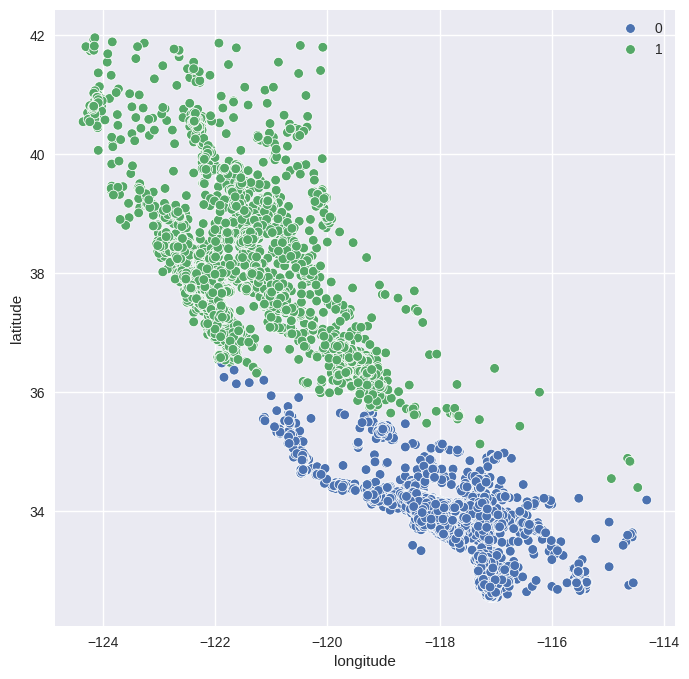

In [86]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

<Axes: xlabel='longitude', ylabel='latitude'>

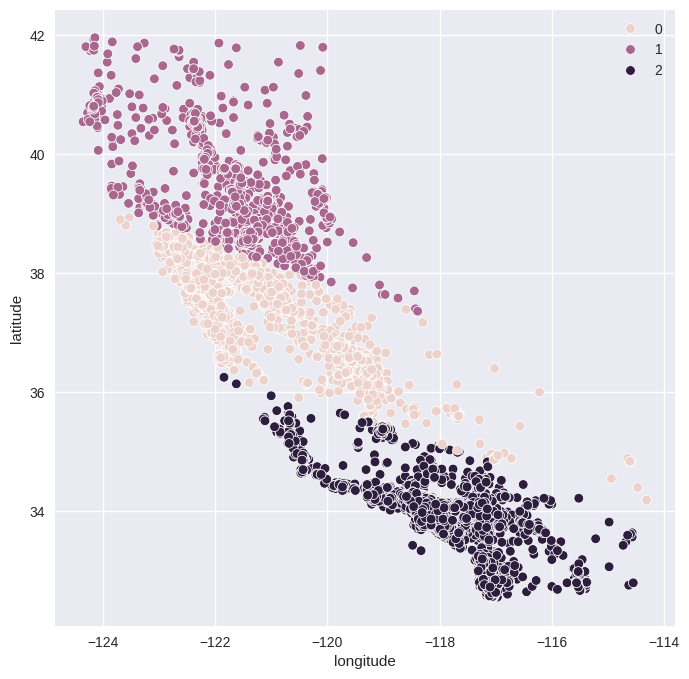

In [87]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[1].labels_)

<Axes: xlabel='longitude', ylabel='latitude'>

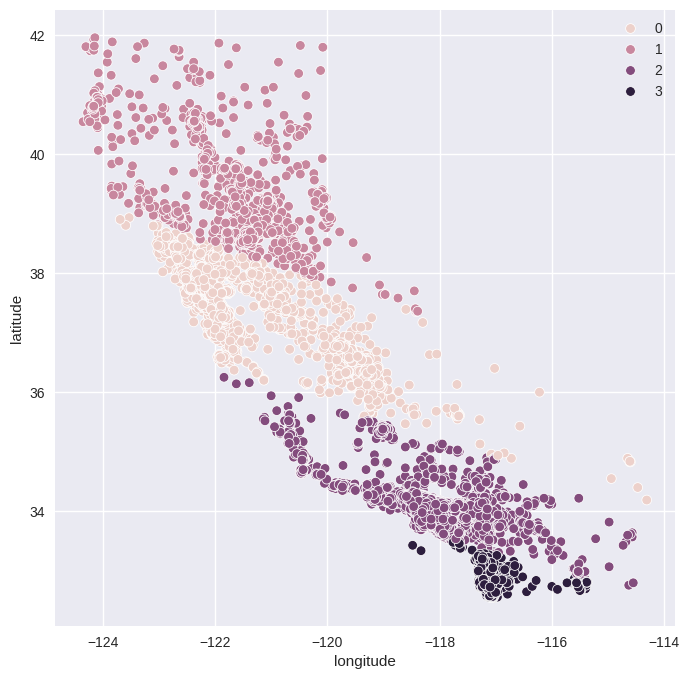

In [88]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

<Axes: xlabel='longitude', ylabel='latitude'>

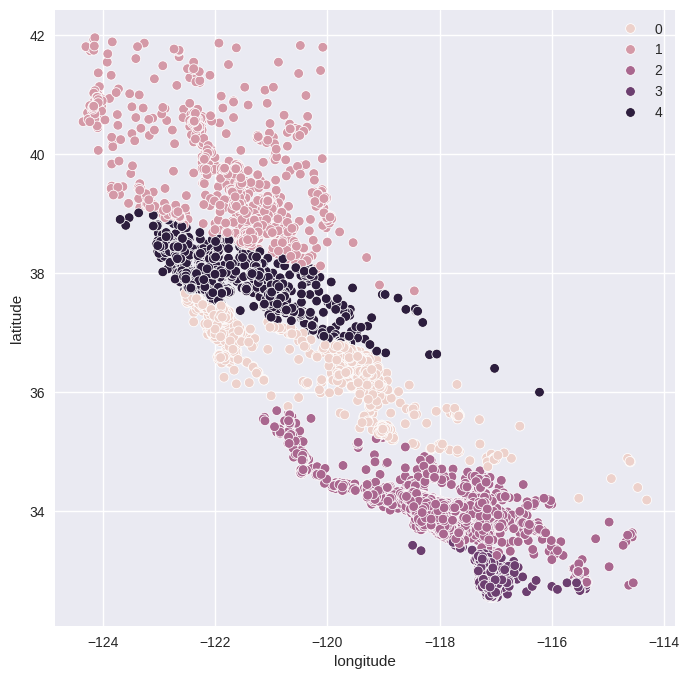

In [89]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

<Axes: >

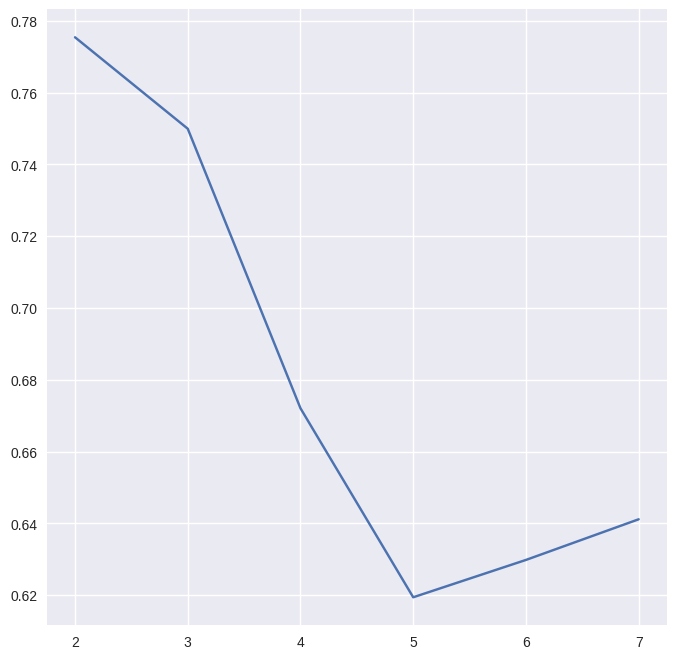

In [90]:
sns.lineplot(x = K, y = score)

Usando el método del codo podemos observar que el mejor núemro de k = 5

<Axes: ylabel='median_house_value'>

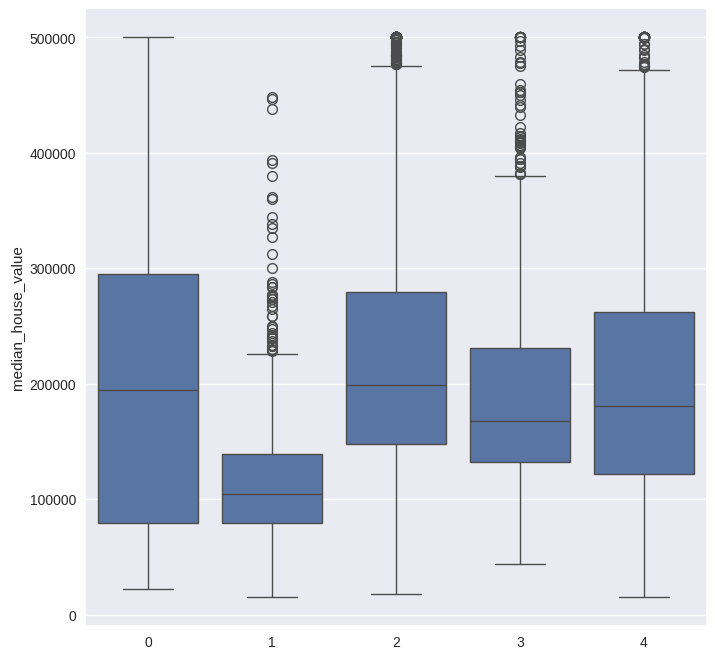

In [91]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'])

<Axes: xlabel='longitude', ylabel='latitude'>

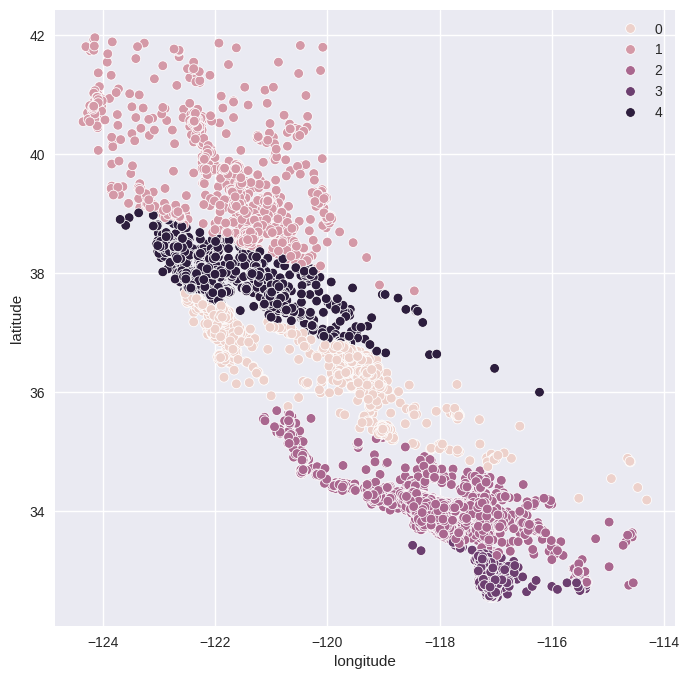

In [92]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

# Conclusiones

Los gráficos nos muestran que hay una agrupación clara de cada clúster, asociadas a zonas geográficas bien definidas

Se muestran diferencias marcadas en el precio medio de la vivienda.

En la zona inferior derecha del mapa presenta valores medianos más elevados en comparación con otros clústeres.

Hay clústeres con precios medianos significativamente más bajos (como el clúster 0), podría ser una zona en el interior o con poca urbanización.

El 2 y el 3 tienen más dispersión y precios más caros, probablemente sean zonas con mayor demanda inmobiliaria.

Dentro de cada cluster hay diferencias que pueden responder a la existencia de viviendas más lujosas dentro de una zona menos urbana.



